# ¿Cuánto cuesta vivir?

Este trabajo nace de una pregunta muy simple y muy común:
**¿me alcanza el salario para comprar lo que veo todos los días?**

No es una pregunta teórica.
Es la pregunta que aparece cuando uno entra a una mipyme,
mira una etiqueta, ve el precio de un producto y sin querer hace la cuenta mental
antes de llegar a la caja.

La sensación suele ser confusa:
algunos precios parecen razonables, la mayoria no tanto,
y otros directamente parecen venir de otro planeta.

Para intentar entender ese caos,
decidí mirar los datos con calma.

In [201]:
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from matplotlib.ticker import MultipleLocator

# Cargo el JSON con encoding utf-8 para evitar problemas con las tildes y caracteres raros
with open("Datos.json", "r", encoding="utf-8") as f:

    datos = json.load(f)

In [202]:
 # Uso recursividad para bajar por todos los niveles del diccionario hasta
 # encontrar la key "Precios" que es el dato que me interesa, siendo este mi caso
 # base
def recorrer_json(data, walk, lista_final):
    for keys, values in data.items():
        if keys == "Precios" and isinstance(values, dict):
            prices_product = {}
            for money, prices in values.items():
                if isinstance(prices, (int, float)):
                    prices_product[money] = prices
                    rec = {
                        "Municipio": walk[1] if len(walk) > 1 else None,
                        "mipyme": walk[2] if len(walk) > 2 else None,
                        "categoria": walk[4] if len(walk) > 4 else None,
                        "producto": walk[5] if len(walk) > 5 else None,
                        "precio": prices_product
                    }
                    lista_final.append(rec)
        elif isinstance(values, dict):
            new_walk = walk.copy()
            new_walk.append(keys)
            recorrer_json(values, new_walk, lista_final)
# Guardo todo el camino para que me sea mas facil sacar los datos

def filtrar_moneda (lista_fina, moneda):
  Lista = []
  for walk in lista_fina:
     if "precio" not in walk:
         continue
     prices = walk["precio"]
     if isinstance(prices, dict) and moneda in prices:
         new = {
             "Municipio": walk["Municipio"],
             "mipyme": walk["mipyme"],
             "categoria": walk["categoria"],
             "producto": walk["producto"],
             "precio": prices[moneda]
         }
         Lista.append(new)
  return Lista
# Aseguro que el producto tenga precio en la moneda que elegira el usuario mas adelante
def group_by_products(lista_filtrada):
    products = {}
    for walk in lista_filtrada:
        Product = walk["producto"]
        price = walk["precio"]

        if Product not in products:
            products[Product] = []

        products[Product].append(price)
    return products
# Tuve que agrupar primero por producto para poder sacar el promedio general
# Diccionario: Clave = Nombre Producto -> Valor = Lista de todos sus precios
# encontrados

def remove_duplicates(list):
    seen = set()
    results = []
    for walk in list:
        k = (
            walk.get ("Municipio"),
            walk.get ("mipyme"),
            walk.get ("categoria"),
            walk.get ("producto"),
         )
        if k not in seen:
            seen.add(k)
            results.append(walk)
    return results
# Uso un set() xq asi limpio duplicados q me quedaban al recorrer el json, asi que al convertirlos en tuplas no me da error de unhashable type, ya q el set no acepta diccionarios
def calculate_average(Products):
    promedios = {}
    for product, list_prices in Products.items():
        if len(list_prices) == 0:
            continue
        promedio = round(sum(list_prices) / len(list_prices))
        promedios[product] = promedio
    return promedios

def deviations_average(filtered_data, average):
    result = []
    for walk in filtered_data:
        product = walk ["producto"]
        price = walk["precio"]
        municipio = walk["Municipio"]
        mipyme = walk["mipyme"]
        if product not in average:
            continue
        averages = average[product]
        if average == 0:
            continue
 # La fórmula de la variación porcentual es : (Valor Real - Promedio) / Promedio
        deviation = (price - averages) / averages * 100
 # Asigno puntos según qué tan desviado esté el precio y poder hacer un scatter diciendo cual es mas cara segun la cantidad de puntos que obtiene
        pts = points(deviation)
        rec = {
            "Municipio": municipio,
            "mipyme": walk ["mipyme"],
            "producto": product,
            "precio": price,
            "average": averages,
            "deviation_%": deviation,
            "puntos": pts,
        }
        result.append(rec)
    return result
# la logica de esta funcion es q si no se pasa de un 10% del promedio para la grafica del scatter, aun asi si esta por encima del 0 sume, o si esta por debajo, que reste
def points(deviation_pct):
    if 10 > deviation_pct > 0:
        return 1
    if -10 < deviation_pct < 0:
        return -1
    return int(deviation_pct / 10)

def sum_points(desviations):
    points_mipyme = {}

    for walk in desviations:
        mipyme = walk ["mipyme"]
        points = walk["puntos"]
        if mipyme not in points_mipyme:
            points_mipyme[mipyme] = 0
        points_mipyme[mipyme] += points
    return points_mipyme

def colors (points):
    if points > 40:
        return 'red'
    elif points > 10:
        return 'orange'
    elif points >= 0:
        return 'white'
    elif points >= -10:
        return 'skyblue'
    else:
        return 'green'

def products_area(list):
    cont = {}
    for walk in list:
        municipio = walk["Municipio"]
        if municipio not in cont:
            cont[municipio] = 0
        cont[municipio] += 1
    return cont

def products_peer_mipyme ( lista , nombre_mipyme):
    products = []
    for walk in lista:
        if walk["mipyme"] == nombre_mipyme:
            products.append({
                "producto": walk["producto"],
                "precio": walk["precio"],
            })
    return products

def calclulate_salary(productos, salario):
    results = []
    for walk in productos:
        percent = (walk["precio"] / salario) * 100
        results.append({
            "producto": walk["producto"],
            "porcentaje": percent,
        })
    return results

def prepare_lines (desviaciones):
    data = {}
    for walk in desviaciones:
        product = walk["producto"]
        municipio = walk["Municipio"]
        deviation = walk["deviation_%"]
        if product not in data:
            data[product] = {}
        if municipio not in data[product]:
            data[product][municipio] = []
        data[product][municipio].append(deviation)
    return data

def average_by_municipio(data):
    result = {}

    for producto, municipios in data.items():
        result[producto] = {}
        for municipio, values in municipios.items():
            result[producto][municipio] = sum(values) / len(values)

    return result

def count_by_category(lista_final):
    counts = {}

    for walk in lista_final:
        categoria = walk["categoria"]
        counts[categoria] = counts.get(categoria, 0) + 1

    return counts

def mipymes_aviable(lista):
    mipymes = set()
    for walk in lista:
        if walk["mipyme"] is not None:
            mipymes.add(walk["mipyme"])
    return sorted(mipymes)


In [203]:
lista_final = []
initial_trip = []
recorrer_json(datos, initial_trip, lista_final)
lista_final = remove_duplicates(lista_final)
moneda = filtrar_moneda(lista_final, input("Moneda de análisis (CUP / MLC / USD / EUR): ").upper())


In [204]:
productos_cup = group_by_products(moneda)
promedios_cup = calculate_average(productos_cup)
desviacion = deviations_average(moneda, promedios_cup)
ranking = sum_points(desviacion)
mipymes = list(ranking.keys())
puntos = list(ranking.values())
colores = [colors(p) for p in puntos]
productos_municipio = products_area(lista_final)
municipios = list(productos_municipio.keys())
cantidades = list(productos_municipio.values())

## Ordenemos el mercado (o intentemoslo)

Los datos originales no vienen ordenados,
ni pensados para responder preguntas claras.

Como suele pasar en la vida real,
hay repeticiones, caminos raros y precios mezclados.
Antes de analizar cualquier cosa,
hubo que recorrerlos, limpiarlos y cabe aclarar que
todos los datos se añadieron tal que conforman
un promedio por categoria de todos los productos
disponibles, ningun valor por categoria o producto es
un valor preciso, sino un promedio, debido a lo grande
que era la muestra.

Los precios no significan lo mismo en
todas las monedas, por eso, antes de analizar,
puedes elegir en qué moneda quiere mirar el mercado.

No se cambian los datos,
solo el lente con el que se observan.

## ¿Quién se pasa y quién se queda corto?

Una vez calculado el precio promedio de cada producto,
la siguiente pregunta me fue inevitable:
**¿qué mipymes venden sistemáticamente más caro que el resto?**

Para eso, se comparó cada precio con el promedio de su producto
y se asignaron puntos según qué tan lejos estuviera.
No es un juicio moral.
Es solo una forma de medir qué tan desalineados están los precios.

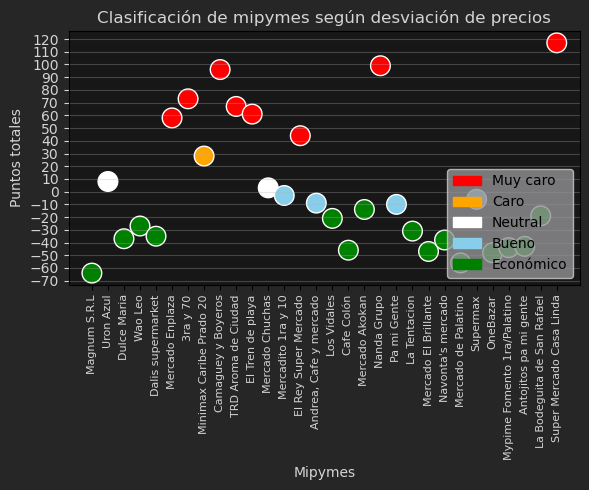

In [205]:
# Hay graficas en las que he tenido que añadir variables y funciones extras para poder hacer lo que he querido
x = range(len(mipymes))

fig, ax = plt.subplots(figsize=(6, 5), facecolor='#262626')
ax.scatter(x, puntos, c=colores, s=200, edgecolors='white')

ax.set_xlabel("Mipymes", color='#d4d4d4')
ax.set_ylabel("Puntos totales", color='#d4d4d4')
ax.set_title("Clasificación de mipymes según desviación de precios", color='#d4d4d4')
ax.set_xticks(x)
ax.set_xticklabels(mipymes, rotation=90, fontsize=8, color='#d4d4d4')
ax.set_facecolor('#171717')
ax.tick_params(axis='y', colors='#d4d4d4')
ax.grid(axis="y", linestyle="-", alpha=0.3)
ax.yaxis.set_major_locator(MultipleLocator(10))
plt.tight_layout()
colores = [patches.Patch(color='red', label='Muy caro'),
           patches.Patch(color='orange', label='Caro'),
           patches.Patch(color='white', label='Neutral'),
           patches.Patch(color='skyblue', label='Bueno'),
           patches.Patch(color='green', label='Económico')]
ax.legend(handles= colores,
          loc='lower right',
          frameon=True,
          facecolor= '#939296',
          labelcolor= 'black')
plt.show()

## Dónde hay más para escoger

Pero el precio no lo es todo.
A veces el problema no es que algo sea caro,
sino que simplemente **no esté disponible**.

Por eso, antes de seguir comparando precios,
miré cuántos productos se concentran en cada municipio.
Más burbuja significa más oferta.

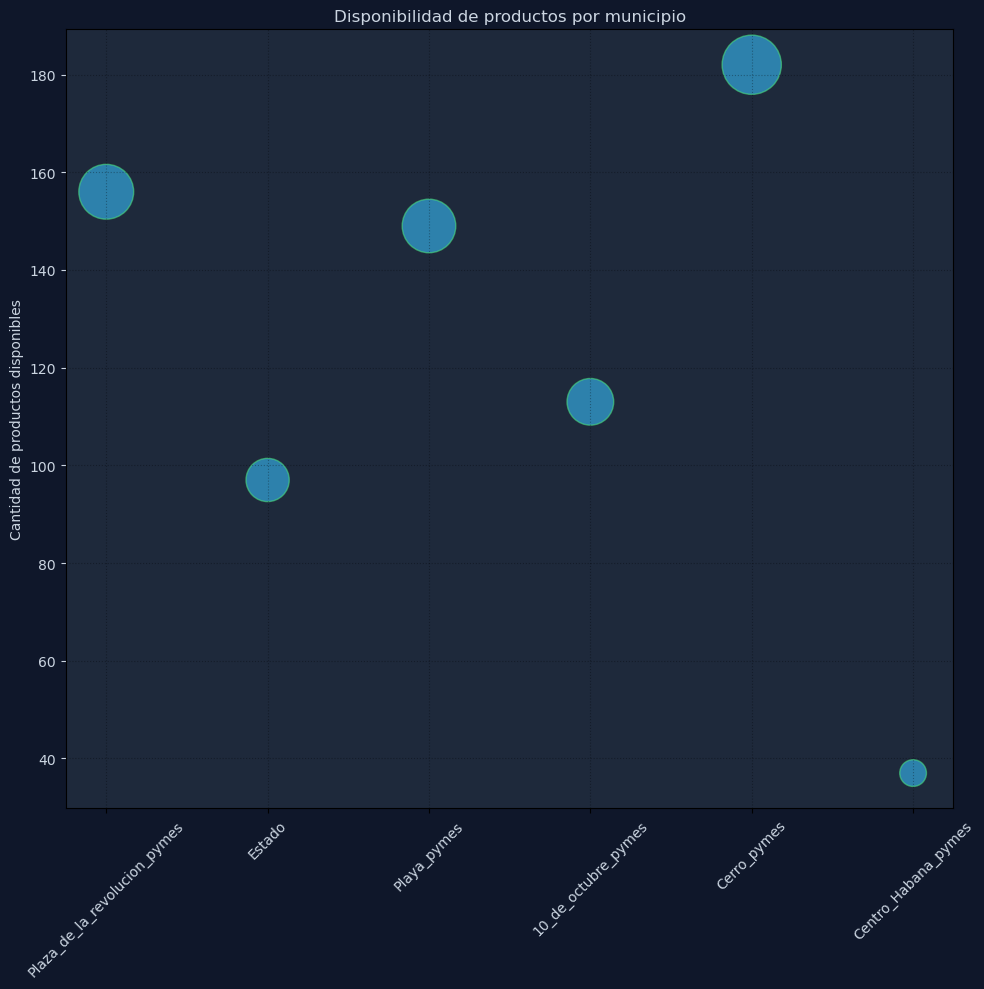

In [206]:
sizes = [c * 10 for c in cantidades]
y = range(len(municipios))
fig, ax = plt.subplots(figsize=(10, 10), facecolor='#0f172a')
ax.scatter(y, cantidades, s=sizes, alpha=0.6, edgecolors = '#4ade80', color = "#38bdf8" )
ax.set_xticks(y)
ax.set_xticklabels(municipios, rotation=45, color= '#cbd5e1' )
ax.set_ylabel("Cantidad de productos disponibles", color='#cbd5e1')
ax.set_title("Disponibilidad de productos por municipio", color= '#cbd5e1')
ax.set_facecolor('#1e293b')
ax.tick_params(axis='y', colors='#cbd5e1')
ax.grid(True, linestyle = ":", alpha = 0.3, color = 'black')
plt.tight_layout()

plt.show()

Visto así, el mercado deja de parecer aleatorio.
Empiezan a aparecer patrones.
Algunas mipymes casi siempre están por encima del promedio.
Otras sorprenden quedándose por debajo.

## El mismo producto, otro municipio, otra historia

Aquí aparece una de las cosas más curiosas del análisis:
el mismo producto puede contar historias muy distintas
dependiendo del municipio donde se venda.

Para visualizarlo,
se tomó el promedio general como punto cero.
Desde ahí, cada línea muestra
qué tan por encima o por debajo se mueve cada municipio.

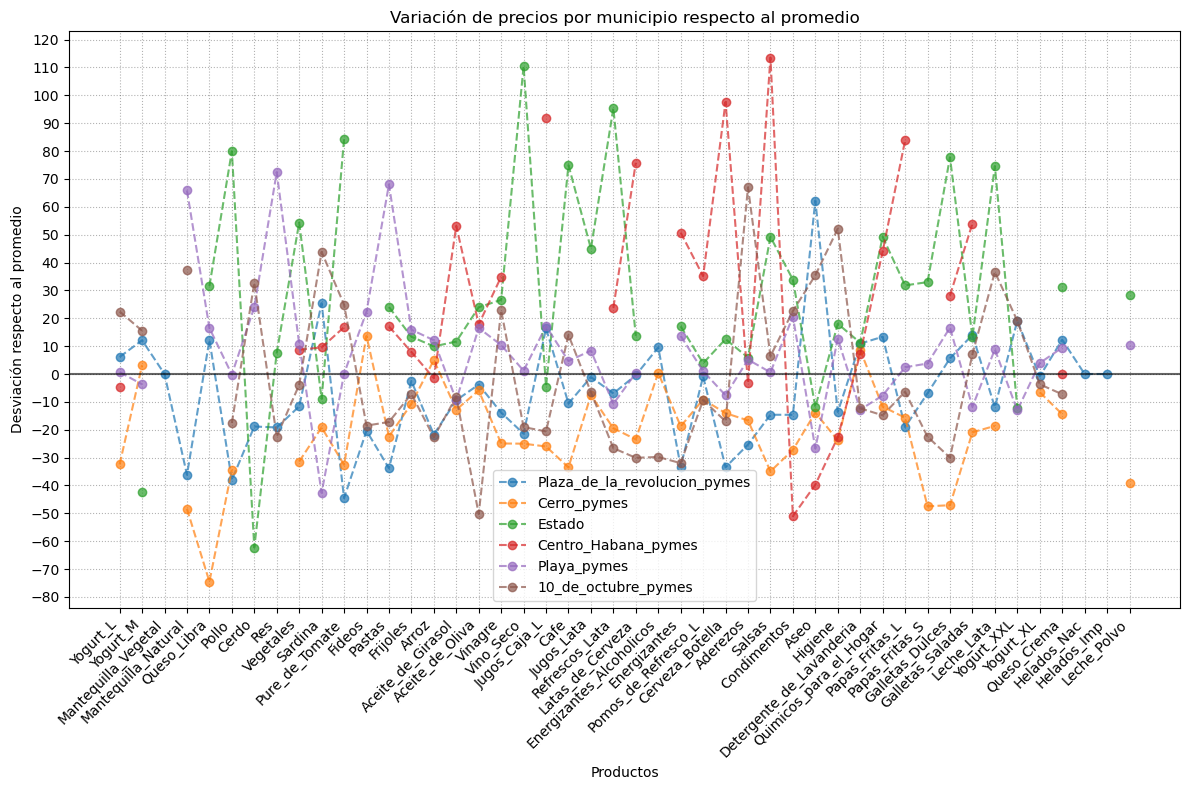

In [208]:
lineas_raw = prepare_lines(desviacion)
lineas = average_by_municipio(lineas_raw)

productos = list(lineas.keys())

municipios = set()
for walk in lineas.values():
    municipios.update(walk.keys())
municipios = list(municipios)

fig, ax = plt.subplots(figsize=(12, 8))
for municipio in municipios:
    y = []
    for producto in productos:
        y.append(lineas[producto].get(municipio, np.nan))
    ax.plot(productos, y, marker="o", linestyle = "--", alpha = 0.7,  label=municipio)
ax.axhline(0, linestyle="-", color="black", alpha=0.6)
ax.set_xlabel("Productos")
ax.set_ylabel("Desviación respecto al promedio")
ax.set_title("Variación de precios por municipio respecto al promedio")
ax.legend()
ax.grid(True, linestyle = ":", alpha = 0.3, color = 'black')
ax.yaxis.set_major_locator(MultipleLocator(10))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## Del dato al bolsillo

Hasta aquí todo ha sido comparación.
Pero faltaba la pregunta más incómoda:

**¿y esto qué significa para alguien que cobra un salario fijo?**

En esta sección, el usuario puede introducir su salario
y elegir una mipyme.
La gráfica muestra qué porcentaje del ingreso
se va en cada producto.

Aquí el análisis deja de ser abstracto.
Se vuelve personal.

Mipymes disponibles:
- 3ra y 70
- Andrea, Cafe y mercado
- Antojitos pa mi gente
- Cafe Colón
- Camaguey y Boyeros
- Dalis supermarket
- Dulce Maria
- El Rey Super Mercado
- El Tren de playa
- La Bodeguita de San Rafael
- La Tentacion
- Los Vidales
- Magnum S.R.L
- Mercadito 1ra y 10
- Mercado Akokan
- Mercado Chuchas
- Mercado El Brillante
- Mercado Enplaza
- Mercado de Palatino
- Minimax Caribe Prado 20
- Mypime Fomento 1ra/Palatino
- Nanda Grupo
- Navonta's mercado
- OneBazar
- Pa mi Gente
- Super Mercado Casa Linda
- Supermax
- TRD Aroma de Ciudad
- Uron Azul
- Wao Leo


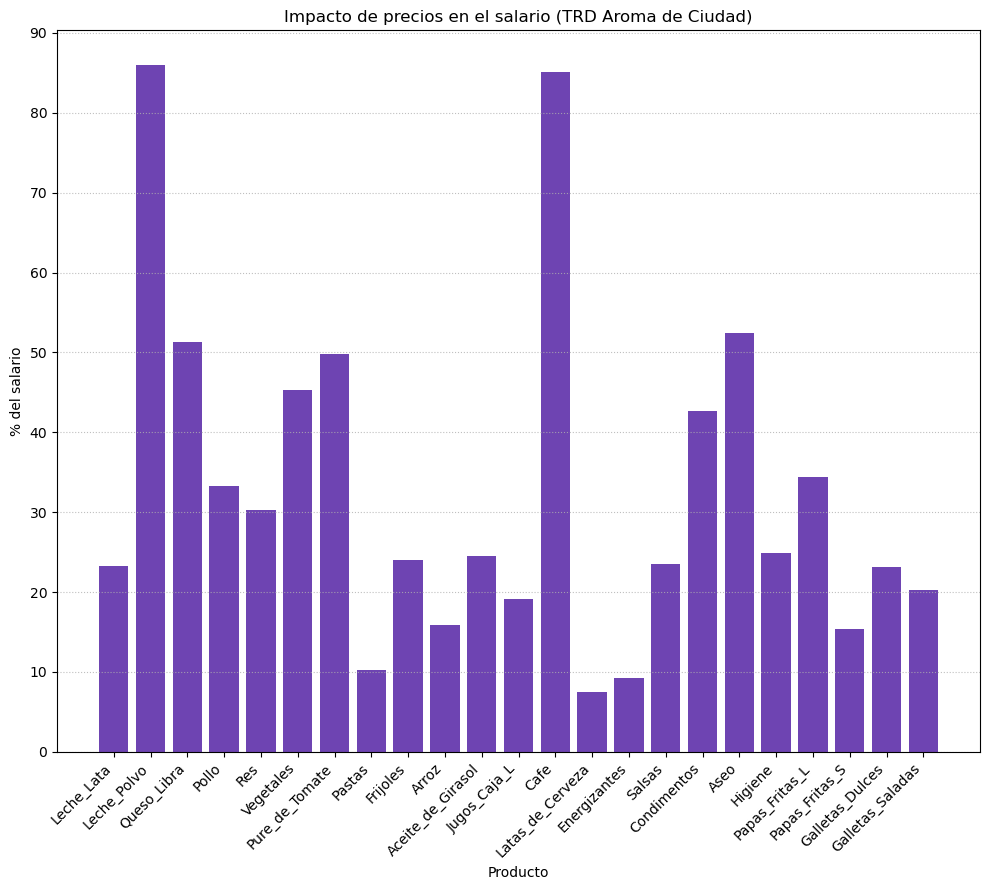

In [210]:
mipymes_disponibles = mipymes_aviable(lista_final)

print("Mipymes disponibles:")
for m in mipymes_disponibles:
    print("-", m)
def grafic_percent_salary(datos, mipyme, salario):
    products = [walk["producto"] for walk in datos]
    percent = [walk["porcentaje"] for walk in datos]
    fig, ax= plt.subplots(figsize=(10, 9))
    ax.bar(products, percent, color= "#6E44B2" )
    ax.set_ylabel("% del salario")
    ax.set_xlabel("Producto")
    ax.set_title(f"Impacto de precios en el salario ({mipyme})")
    ax.set_xticks(range(len(products)))
    ax.set_xticklabels(products, rotation=45, ha="right")
    ax.grid(axis="y", linestyle=":", alpha=0.8)
    ax.yaxis.set_major_locator(MultipleLocator(10))
    plt.tight_layout()
    plt.show()

mipyme_elegida = input("En la consola apareceran los nombres de las mipymes. Introduzca una Mipyme: ".upper() )
salario = float(input("Nota: el salario introducido debe estar expresado en la misma moneda elegida. Diga su salario: "))

productos = products_peer_mipyme(moneda, mipyme_elegida)
impacto = calclulate_salary(productos, salario)

grafic_percent_salary(impacto, mipyme_elegida, salario)

## ¿Qué se vende realmente?

Para cerrar, una mirada más general:
no a los precios,
sino a **qué tipo de productos dominan el mercado**.

Esta gráfica no explica el problema,
pero ayuda a entender el contexto:
qué categorías aparecen más,
y cuáles son casi anecdóticas.

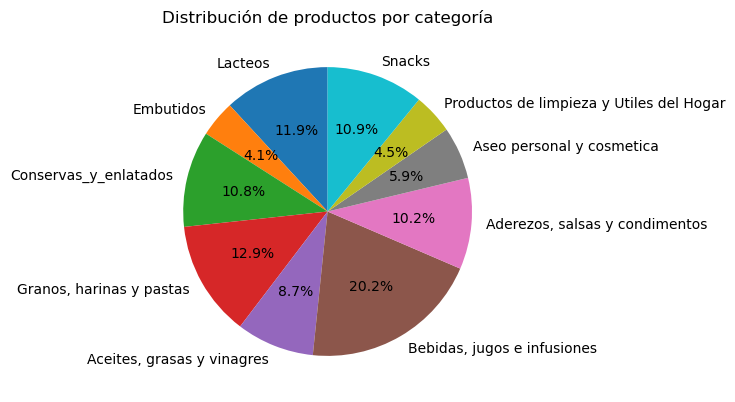

In [211]:
categorias = count_by_category(lista_final)

labels = list(categorias.keys())
sizes = list(categorias.values())

plt.figure(figsize=(7, 7))
plt.pie(
    sizes,
    labels=labels,
    autopct='%1.1f%%',
    startangle=90
)
plt.title("Distribución de productos por categoría")
plt.tight_layout()
plt.show()

## ¿Que más a decir?
Este análisis no da respuestas definitivas.
No dice dónde comprar,
ni qué mipyme es “buena” o “mala”. (o sí)

Pero sí deja algo claro:
los precios no se distribuyen al azar,
y el salario siempre está presente,
aunque no aparezca en la etiqueta.

Al final, los datos solo confirmaron
algo que ya sabíamos antes de abrir el notebook:
¡¡Que cara esta La Habana!!